Actions in Snapshot 24 in different potentials
---


In [17]:
from galpy.potential import MWPotential2014, NFWPotential, HernquistPotential, MiyamotoNagaiPotential, DoubleExponentialDiskPotential
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel
from galpy.actionAngle import UnboundError
from galpy.potential import plotPotentials

import numpy as np

from astropy import units as u

import matplotlib.pyplot as plt
import corner

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import datetime

%matplotlib inline

In [2]:
machine = 'mac'
machine = 'magny'

if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
else:
    raise NotADirectoryError

In [3]:
halo_number = 24  # range(1, 31):
halodir = basedir + "halo_{0}/".format(halo_number)
snappath = halodir + "output/"

s, sf = eat_snap_and_fof(4, 24, 127, snappath, loadonlytype=[0,1,2,3,4,5], 
                haloid=0, galradfac=0.1, verbose=True) 
s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 ) 

m_enc = np.sum(s.mass[(s.r()<0.008)])

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [4]:

def getIDmask(num):
    IDS = np.loadtxt(filedir + 'surviving_ids_snapshot_' + str(num) + '_sh_1.txt', dtype = 'int')
    gcmask = np.isin(s.id, IDS)
    return(gcmask, IDS)

In [5]:
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc / _REFR0_kpc
    b_MND  = b_MND_kpc / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB)
    return [disk, halo, bulge]


In [6]:
# potential after changing potential fitting process
R0_kpc = 8.028522133827
v0_kms = 220.724646623532
a_MND_kpc = 2.965077197428
b_MND_kpc = 1.636277572036
a_HB_kpc = 1.715455282866
a_NFWH_kpc = 26.015274934508
v0_MND_kms = 105.005287927966
v0_HB_kms= 111.241910552340
v0_NFWH_kms = 159.117869740997
n_MND       = v0_MND_kms**2  / v0_kms**2
n_HB        = v0_HB_kms**2   / v0_kms**2
n_NFWH      = v0_NFWH_kms**2 / v0_kms**2

pot_fit2 = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, R0_kpc)

# potential before changing potential fitting process
v0_kms_bestfit = 2.103570533272526575e+02 
a_MND_kpc_bestfit = 1.825567540634966068e+00 
b_MND_kpc_bestfit = 1.857005195746084780e+01 
a_NFWH_kpc_bestfit = 1.052331394026586651e+02 
a_HB_kpc_bestfit = 1.662002037546861821e+00 
n_MND_bestfit = 1.715091913322144834e-01 
n_NFWH_bestfit = 1.094429123318183678e-01 
n_HB_bestfit = 7.190478963359672182e-01 

pot_fit1 = setup_galpy_potential(a_MND_kpc_bestfit, b_MND_kpc_bestfit, a_NFWH_kpc_bestfit, a_HB_kpc_bestfit, n_MND_bestfit, n_NFWH_bestfit, n_HB_bestfit, 8.)

In [7]:

MW14 = MWPotential2014
mp = MiyamotoNagaiPotential(amp = 10**10*m_enc)
nfwp = NFWPotential(amp = 10**10*m_enc)
hp = HernquistPotential(amp = 10**10*m_enc)
dep = DoubleExponentialDiskPotential(amp = 10**10*m_enc)

pot_list = [MW14, mp, nfwp, hp, dep, pot_fit1, pot_fit2]
pot_names = ['MW14', 'mp', 'nfwp', 'hp', 'dep', 'pot_fit1', 'pot_fit2']

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:803: RuntimeWarning: invalid value encountered in double_scalars
  return -numpy.log(1.+r/self.a)/r

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/PowerSphericalPotentialwCutoff.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.*nu.pi*self.rc**(3.-self.alpha)/r*(r/self.rc*special.gamma(1.-self.alpha/2.)*special.gammainc(1.-self.alpha/2.,(r/self.rc)**2.)-special.gamma(1.5-self.alpha/2.)*special.gammainc(1.5-self.alpha/2.,(r/self.rc)**2.))

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/PowerSphericalPotentialwCutoff.py:92: RuntimeWarning: in

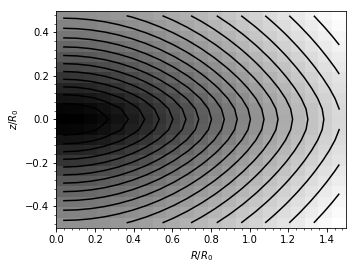

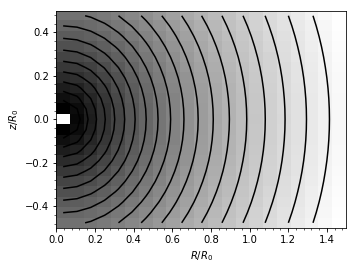

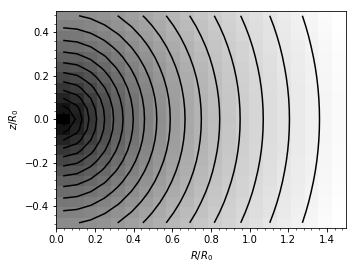

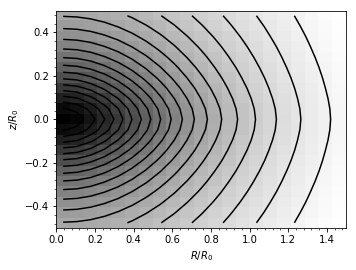

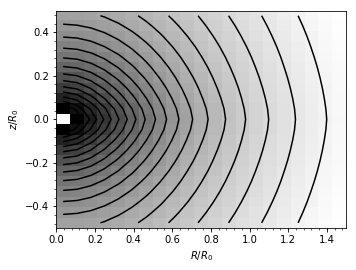

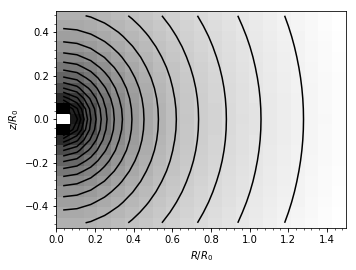

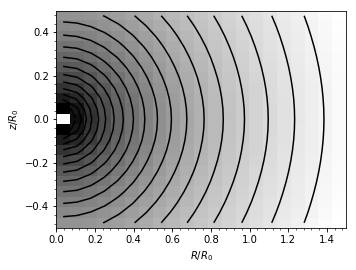

In [25]:
mp.plot()
nfwp.plot()
hp.plot()
dep.plot()
plotPotentials(MW14)
plotPotentials(pot_fit1)
plotPotentials(pot_fit2)

In [31]:
def actions(pot, num, init, color, figure = None):
    _REFR0_kpc = 8.
    _REFV0_kms = 220.
    gcmask, IDS = getIDmask(num)
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
    R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms
    # estimate Delta of the Staeckel potential
    #delta = 0.45
    try:
        delta = estimateDeltaStaeckel(pot, R_galpy, z_galpy)
    except:
        delta = 0.4
    # CHECK HOW BIG INFLUENCE OF DELTA IS

    print('delta', delta)
    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = pot,  # potential
            delta = 0.4,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    
    #calculate actions and convert them to physical units
    r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
    
    jR_galpy, lz_galpy, jz_galpy, r_kpc = np.zeros(len(IDS)), np.zeros(len(IDS)), np.zeros(len(IDS)), np.zeros(len(IDS))
    savedids = np.zeros(len(IDS))
    ids_notworking = []
    for test_i, item in enumerate(IDS):
        if (test_i % 1000) == 0:
            print(datetime.datetime.now().time())
            print(test_i)
        if np.sum(np.isin(r_condition, test_i)):
            try: 
                jR_galpy[test_i], lz_galpy[test_i], jz_galpy[test_i] = aAS(R_galpy[test_i], vR_galpy[test_i], vT_galpy[test_i], z_galpy[test_i], vz_galpy[test_i])
                r_kpc[test_i] = np.sqrt(R_kpc[test_i]**2 + z_kpc[test_i]**2)
                savedids[test_i] = item
            except(ValueError, UnboundError):
                ids_notworking.append(item)
                continue
    print('numbers of GCs wo actions:', len(ids_notworking))
    print(len(IDS))
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

    # just pick result values of particles of which I actually could calculate actions
    survivor_id_mask = np.isin(IDS, savedids)
    jR_kpckms, lz_kpckms, jz_kpckms = jR_kpckms[survivor_id_mask], lz_kpckms[survivor_id_mask], jz_kpckms[survivor_id_mask]
    r_kpc = r_kpc[survivor_id_mask]
    survivor_ids = IDS[survivor_id_mask]
    print(len(survivor_ids))
    #jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    #jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    print(data)
    
    if init == 0:
        print('Figure started')
        figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,6.5e8), (-14000.,14000.),(0., 4e8)])
        
    else:
        figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,6.5e8), (-14000.,14000.),(0., 4e8)])            
    return(figure)
    '''
    plt.hist(jR_kpckms)
    plt.xlabel('jR')
    plt.show()
    plt.hist(jz_kpckms)
    plt.xlabel('jz')
    plt.show()
    plt.hist(lz_kpckms)
    plt.xlabel('lz')
    plt.show()
    '''
    #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));

    #display(figure)
    #if repeater == 0:
        #print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))


MW14
mp
nfwp
hp
dep
pot_fit1
5 0
delta 0.590817833557
16:00:35.766725
0
16:01:21.601523
1000
16:01:37.757490
2000
numbers of GCs wo actions: 0
2648
1365
[[   379.87716697    322.28660303     21.30732551 ...,   9348.97753925
    5135.47102128   8622.58984526]
 [   439.37157154   -670.36416531   -712.88848877 ...,  -1875.84798813
  -10287.02087402   3807.80796051]
 [   325.70807154    748.23260791   1077.93213906 ...,     60.83080058
     606.48570342   3383.9902891 ]]
Figure started


delta 0.78107125741
16:02:26.398552
0
16:03:12.722270
1000
16:03:59.115725
2000
16:04:30.408227
3000
16:05:05.638592
4000
16:05:26.039074
5000
16:05:52.385258
6000
16:05:56.685578
7000
16:06:07.934456
8000
16:06:17.329684
9000


numbers of GCs wo actions: 0
9785
5006
[[   127.87621188     19.5295265     129.13803168 ...,   6052.32721014
    6101.32798569   6137.48782598]
 [  -765.34671307   -885.71696281  -1254.87297058 ..., -11562.4030304
  -10428.40568542  -8052.92366028]
 [   347.29542187    414.11775133    253.48531925 ...,    266.23521575
    1686.35293354   2926.01307648]]


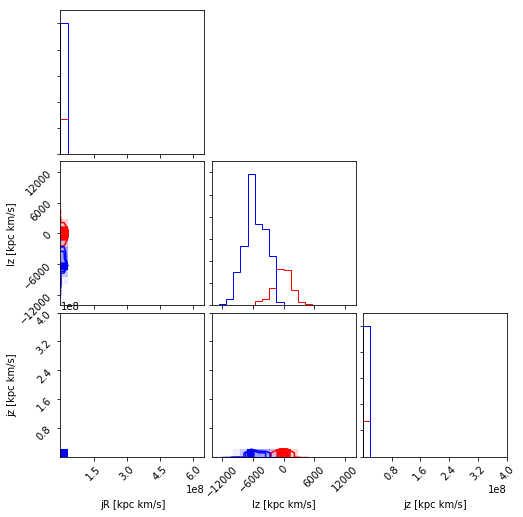

pot_fit2
6 0
delta 0.125833872454
16:07:15.070910
0
16:08:01.595944
1000
16:08:17.939417
2000
numbers of GCs wo actions: 0
2648
1365
[[   352.80530175    287.75727571     19.06149226 ...,   8270.00812128
    4350.49432815   7467.60405222]
 [   439.37157154   -670.36416531   -712.88848877 ...,  -1875.84798813
  -10287.02087402   3807.80796051]
 [   360.77203525    705.37276997   1050.57326408 ...,     65.45776227
     609.21922273   3406.95496272]]
Figure started


delta 0.164766751299
16:09:02.819275
0
16:09:49.426887
1000
16:10:35.935801
2000
16:11:07.359424
3000
16:11:42.775873
4000
16:12:03.315012
5000
16:12:29.899426
6000
16:12:34.209392
7000
16:12:45.540093
8000
16:12:54.981921
9000


numbers of GCs wo actions: 0
9785
5006
[[    91.39781753     38.6725584     121.60099219 ...,   4739.82853455
    4817.30080714   5091.71302282]
 [  -765.34671307   -885.71696281  -1254.87297058 ..., -11562.4030304
  -10428.40568542  -8052.92366028]
 [   330.81627544    425.56947976    235.99343151 ...,    266.55658793
    1692.44143432   2938.51532742]]


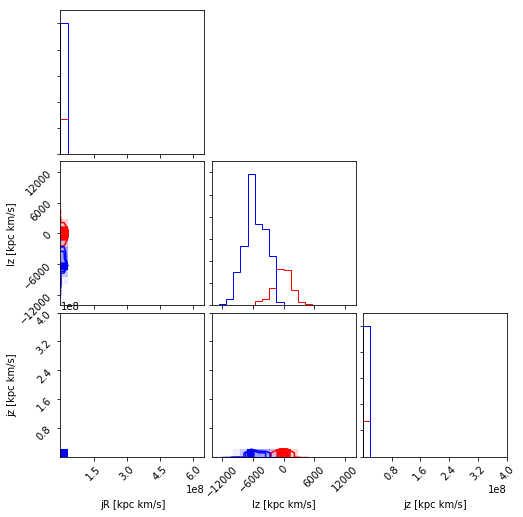

In [37]:
num = [67, 73]
init = 0
color = ['red', 'blue']
for ii,i_pot in enumerate(pot_list):
    print(pot_names[ii])
    init = 0
    #if ii == 4:# or ii == 1:# or ii ==3:
        #continue
    if ii == 0 or ii == 1 or ii ==2 or ii ==3 or ii == 4:
        continue
    for jj, j_num in enumerate(num):
        if init == 0:
            print(ii,jj)
            figure = actions(i_pot, j_num, init, color[jj])
            init +=1
        else:
            figure = actions(i_pot, j_num, init, color[jj], figure)
            figure.savefig(plotdir + 'actions_dwarf_' + str(j_num) + 'in_'+str(pot_names[ii])+'_pot_comparison.png', dpi = 300, format = 'png') 
    plt.show()